# Targeted protein quantification from list of targets generated in R
needed to use R for peptide-to-protein mapping, jump back here to do quant because it is much faster

### All files needed for quant are on github at:
DI2A/data/targeted_quant

In [1]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass
import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pylab import rcParams
from sklearn.metrics import r2_score


from scipy.stats import ttest_ind, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.multitest import multipletests

import scikit_posthocs as sp

### Functions to match intensities, m/z, and to get quant frags from the target table

In [2]:
#DIRECTORY = "P:/JGM_DI2A/MSDATA/20200217_FIDIA_mitotox3_targeted/"
PATH = 'P:/JGM_DI2A/Python/outputs/mitotox3/20200305_mitoTox_final_data/'

In [3]:
dfmerge = pd.read_csv(PATH+'1ions12ppm_protein_quant_data_table.csv')

# Keep only the proteins with at least 2 measures in each conditions

In [11]:
df6h = dfmerge[dfmerge['Control group']=='6 hr']
df24h = dfmerge[dfmerge['Control group']=='24h']
df24h.head()

,Unnamed: 0,key_0,Sample,Cell line,Genotype,Media,Compound,concentration,Treatment duration,Control group,...,xCX6B1_HUMAN,xTCTP_HUMAN,xMARE1_HUMAN,xRL30_HUMAN,xVDAC1_HUMAN,xFPPS_HUMAN,xTRAP1_HUMAN,xSYMC_HUMAN,xTXNL1_HUMAN,xRBM8A_HUMAN
84,84,85,85,293T,WT,DMEM,4-NB,1 mM,7 day,24h,...,0.060563,-0.594394,-0.079220,0.015354,-0.208599,0.357648,-0.244762,1.140630,1.692158,2.174907
85,85,86,86,293T,WT,DMEM,4-NB,1 mM,7 day,24h,...,0.987311,-0.615167,-1.319713,0.029817,-0.200257,0.702699,1.057101,1.262653,1.380081,1.602328
86,86,87,87,293T,WT,DMEM,4-NB,1 mM,7 day,24h,...,0.142307,-0.867102,-0.147405,-2.349797,-0.518479,0.161465,-0.129915,0.785918,1.034025,0.821583
87,87,88,88,293T,WT,HPLM,4-NB,1 mM,7 day,24h,...,0.606894,-0.820729,NaN,-0.045384,0.073957,0.674998,0.783918,1.463818,0.389657,0.773647
88,88,89,89,293T,WT,HPLM,4-NB,1 mM,7 day,24h,...,-0.077636,-0.619734,NaN,0.170500,-0.015437,0.470689,0.224004,1.243243,0.227852,0.699431


In [12]:
filter_col = [col for col in df24h if col.startswith('x')]
filter_col = ['class']+filter_col
#filter_col

In [13]:
df24h_filter = df24h[filter_col]
#df24h_filter['class']

In [14]:
na_counts_24h = df24h_filter.drop('class',1).isna().groupby(df24h_filter['class'], sort=False).sum().reset_index()

In [15]:
prot_names_24h_atleast1 = na_counts_24h.max().drop('class',0).index[na_counts_24h.max().drop('class',0)<3]
prot_names_24h_atleast2 = na_counts_24h.max().drop('class',0).index[na_counts_24h.max().drop('class',0)<2]
prot_names_24h_atleast3 = na_counts_24h.max().drop('class',0).index[na_counts_24h.max().drop('class',0)<1]

print('24h profiles with at least 3 replicates for each profile = '+str(len(prot_names_24h_atleast3)))
print('24h profiles with at least 2 replicates for each profile = '+str(len(prot_names_24h_atleast2)))
print('24h profiles with at least 1 replicates for each profile = '+str(len(prot_names_24h_atleast1)))

24h profiles with at least 3 replicates for each profile = 380
24h profiles with at least 2 replicates for each profile = 401
24h profiles with at least 1 replicates for each profile = 411


In [16]:
#df24h_filter[prot_names_24h_atleast3]

In [17]:
### change order of 24hr df so the controls are first
#df24h = df24h.reindex(index=df24h.index[::-1])
df24h = df24h.iloc[np.arange(-12, len(df24h)-12)]

In [18]:
df6h_filter = df6h[filter_col]
na_counts_6h = df6h_filter.drop('class',1).isna().groupby(df6h_filter['class'], sort=False).sum().reset_index()
na_counts_6h
prot_names_6h_atleast3 = na_counts_6h.max().drop('class',0).index[na_counts_6h.max().drop('class',0)<1]
prot_names_6h_atleast2 = na_counts_6h.max().drop('class',0).index[na_counts_6h.max().drop('class',0)<2]
prot_names_6h_atleast1 = na_counts_6h.max().drop('class',0).index[na_counts_6h.max().drop('class',0)<3]
print('6h profiles with at least 3 replicates for each profile = ' + str(len(prot_names_6h_atleast3)))
print('6h profiles with at least 2 replicates for each profile = ' + str(len(prot_names_6h_atleast2)))
print('6h profiles with at least 1 replicates for each profile = ' + str(len(prot_names_6h_atleast1)))


6h profiles with at least 3 replicates for each profile = 341
6h profiles with at least 2 replicates for each profile = 386
6h profiles with at least 1 replicates for each profile = 399


In [19]:
protein_names = [col for col in dfmerge if col.startswith('x')]
protein_names = [str(x).split('x')[1] for x in protein_names]
len(protein_names)

431

In [20]:
#pd.DataFrame(protein_names).to_csv(PATH+'all_protein_targets.csv')

In [21]:
PATH

'P:/JGM_DI2A/Python/outputs/mitotox3/20200305_mitoTox_final_data/'

In [22]:
### glycolysis proteins:
glyco = ['xTPIS_HUMAN', 'xG3P_HUMAN', 'xKPYM_HUMAN', 
         'xPGAM1_HUMAN', 'xPGK1_HUMAN', 'xALDOA_HUMAN', 'xG6PI_HUMAN', 'xLDHA_HUMAN', 'xLDHB_HUMAN']

In [23]:
### order is: WT DMEM, WT DMEM+ DFO, WT HPLM, WT HPLM +DFO, then same for mutant
samples_DFO = [121, 122, 123, 97, 98, 99, 124, 125, 126, 100, 101, 102, 127,128,129, 103,104,105, 130,131,132, 106,107,108]

In [24]:
## because the index is off by 1
DFO_index = [x-1 for x in samples_DFO]

In [25]:
DFO_heatmap = dfmerge[glyco].T[DFO_index]
DFO_heatmap

,120,121,122,96,97,98,123,124,125,99,...,128,102,103,104,129,130,131,105,106,107
xTPIS_HUMAN,-0.810143,-0.770108,-0.667369,0.059175,-0.134931,-0.031648,-0.419238,-0.335080,-0.546320,-0.367896,...,-0.951768,-1.191105,-0.116101,-0.489937,-1.045076,-1.024138,-0.504905,-0.611259,-0.073214,-0.502016
xG3P_HUMAN,0.245898,0.080249,0.307661,0.606956,0.600517,0.665965,0.230636,0.119783,0.085571,0.427361,...,0.232973,0.453299,0.567987,0.657155,0.220125,0.195644,0.102607,0.340933,0.390889,0.357780
xKPYM_HUMAN,-0.085310,-0.260041,-0.409435,0.126196,0.504235,0.662762,-0.137213,0.035440,0.104751,0.180938,...,-0.078945,0.380758,0.472526,0.592626,0.101575,0.245975,-0.015732,0.363497,0.309498,0.289756
xPGAM1_HUMAN,-0.350058,-0.297489,-0.420127,0.237492,0.246126,0.104613,-0.098441,-0.046928,-0.292997,0.262671,...,-0.735168,-0.292242,0.097554,-0.170858,-0.525817,-0.388286,-0.552281,0.207141,-0.115252,-0.093993
xPGK1_HUMAN,0.232360,0.253126,0.053819,1.064449,1.144851,1.414408,0.275526,-0.126399,-0.010579,1.526658,...,0.320759,1.379373,1.530020,1.415393,-0.127015,0.204075,-0.040613,1.210845,1.109839,1.423627
xALDOA_HUMAN,-0.305323,-0.228817,-0.183990,0.699085,1.055928,0.830092,-0.066584,0.375010,-0.520572,0.312428,...,-0.003038,0.940571,0.417004,0.544661,0.026406,0.009664,-0.604911,-0.053042,0.286360,0.445287
xG6PI_HUMAN,-0.335783,-0.512326,-0.340931,-0.007394,0.151806,0.163544,-0.373997,-0.151616,-0.443104,-0.096185,...,-0.425796,-0.166135,0.027969,0.014791,-0.238951,-0.409003,-0.163776,-0.353748,-0.254871,-0.123599
xLDHA_HUMAN,0.213729,0.381741,0.306015,1.167958,1.487602,1.090835,0.706766,0.325024,0.383498,1.182774,...,0.499955,1.187990,1.182190,1.231722,0.294385,0.474601,0.102955,1.045528,1.033466,1.008061
xLDHB_HUMAN,-0.029463,-0.089600,0.108786,0.079562,0.085489,0.104531,0.079312,0.229462,0.222595,0.189392,...,-0.311815,-0.124179,-0.147419,-0.022209,0.063586,0.118973,-0.179565,-0.030301,0.009641,0.137282


In [142]:
## take the average of each of every three values, make new dataframe sequentially
nconditions = 8

DFO_mean_hm = pd.DataFrame(columns=['WT DMEM', 'WT DMEM + DFO', 'WT HPLM', 'WT HPLM +DFO', 
                                   'dPPTC7 DMEM', 'dPPTC7 DMEM + DFO', 'dPPTC7 HPLM', 'dPPTC7 HPLM + DFO'], 
                           index=DFO_heatmap.index)

pvalues = []

for idx in DFO_heatmap.index:
    #print(DFO_heatmap.loc[idx])
    for i in range(0, nconditions):
        DFO_mean_hm.loc[idx][i] = np.mean(DFO_heatmap.loc[idx][3*i:3*i+3])
        if i % 2 ==1:
            pvalues.append(ttest_ind(DFO_heatmap.loc[idx][3*(i-1):3*(i-1)+3], DFO_heatmap.loc[idx][3*i:3*i+3])[1])

In [143]:
pvalues

[0.0005329775431433035,
 0.2592263187278593,
 0.6580886773422325,
 0.1276028352384633,
 0.0043436664184346736,
 0.0028456025206323545,
 0.004756716811507784,
 0.007919951154896566,
 0.020896604045574384,
 0.0351588272552112,
 0.002506199748061548,
 0.05592180387871069,
 0.0006788310957296525,
 0.011479108142877717,
 0.004804408130173929,
 0.013551704094499422,
 0.0011303107808274886,
 0.0030767430472830124,
 0.00041013814719056686,
 0.0008033858587858827,
 0.000561298143184331,
 0.13825141716579065,
 0.03622562344021425,
 0.1775495368888655,
 0.003370020805219873,
 0.09907512006250956,
 0.004218199925782962,
 0.8012055388870911,
 0.0019222266757643195,
 0.027265050608035423,
 0.0007290317537675566,
 0.0023835574470869128,
 0.19026716063719876,
 0.8750726462406841,
 0.9829659767031682,
 0.7358127653720886]

In [144]:
cell_labels = np.full((36,), ' ')
print(cell_labels)

[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
 ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']


In [145]:
print(cell_labels)
cell_labels[np.where(multipletests(pvalues, 0.05, 'fdr_bh')[0])] = '*'
print(cell_labels)
cell_labels[np.where(multipletests(pvalues, 0.01, 'fdr_bh')[0])] = '&'
print(cell_labels)



[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
 ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
['*' ' ' ' ' ' ' '*' '*' '*' '*' '*' ' ' '*' ' ' '*' '*' '*' '*' '*' '*'
 '*' '*' '*' ' ' ' ' ' ' '*' ' ' '*' ' ' '*' '*' '*' '*' ' ' ' ' ' ' ' ']
['&' ' ' ' ' ' ' '*' '&' '*' '*' '*' ' ' '&' ' ' '&' '*' '*' '*' '&' '&'
 '&' '&' '&' ' ' ' ' ' ' '&' ' ' '*' ' ' '&' '*' '&' '&' ' ' ' ' ' ' ' ']


In [157]:
# save adjusted p value table
pd.DataFrame(np.asarray(pvalues).reshape(9,4).T, index=DFO_FC_df.T.index,
            columns=DFO_FC_df.T.columns)


,xTPIS_HUMAN,xG3P_HUMAN,xKPYM_HUMAN,xPGAM1_HUMAN,xPGK1_HUMAN,xALDOA_HUMAN,xG6PI_HUMAN,xLDHA_HUMAN,xLDHB_HUMAN
WT DMEM + DFO,0.000533,0.004344,0.020897,0.000679,0.001130,0.000561,0.003370,0.001922,0.190267
WT HPLM + DFO,0.259226,0.002846,0.035159,0.011479,0.003077,0.138251,0.099075,0.027265,0.875073
dPPTC7 DMEM + DFO,0.658089,0.004757,0.002506,0.004804,0.000410,0.036226,0.004218,0.000729,0.982966
dPPTC7 HPLM + DFO,0.127603,0.007920,0.055922,0.013552,0.000803,0.177550,0.801206,0.002384,0.735813


In [156]:
## save raw p value table


# save adjusted p value table
pd.DataFrame(np.asarray(pvalues).reshape(9,4).T, index=DFO_FC_df.T.index,
            columns=DFO_FC_df.T.columns).to_csv('P:/JGM_DI2A/Python/outputs/mitotox3/DFO_raw_pvalues.csv')


In [155]:
# save adjusted p value table
pd.DataFrame(multipletests(pvalues, 0.01, 'fdr_bh')[1].reshape(9,4).T, index=DFO_FC_df.T.index,
            columns=DFO_FC_df.T.columns).to_csv('P:/JGM_DI2A/Python/outputs/mitotox3/DFO_BHcorrected_pvalues.csv')

In [152]:
cell_labels.reshape(9,4).T

array([['&', '*', '*', '&', '&', '&', '&', '&', ' '],
       [' ', '&', ' ', '*', '&', ' ', ' ', '*', ' '],
       [' ', '*', '&', '*', '&', ' ', '*', '&', ' '],
       [' ', '*', ' ', '*', '&', ' ', ' ', '&', ' ']], dtype='<U1')

In [31]:
['*' for x in multipletests(pvalues)[0] if x==True]

['*', '*', '*', '*', '*', '*', '*']

In [45]:
## because ratios are in log space, getting the fold change means subtracting them
DFO_FC_df = pd.DataFrame(DFO_mean_hm['WT DMEM + DFO']  - DFO_mean_hm['WT DMEM'])
DFO_FC_df.columns = ['WT DMEM + DFO']
DFO_FC_df['WT HPLM + DFO'] = DFO_mean_hm['WT HPLM +DFO']  - DFO_mean_hm['WT HPLM']
DFO_FC_df['dPPTC7 DMEM + DFO'] = DFO_mean_hm['dPPTC7 DMEM + DFO']  - DFO_mean_hm['dPPTC7 DMEM']
DFO_FC_df['dPPTC7 HPLM + DFO'] = DFO_mean_hm['dPPTC7 HPLM + DFO']  - DFO_mean_hm['dPPTC7 HPLM']


In [161]:
DFO_FC_df.T.to_csv('P:/JGM_DI2A/Python/outputs/mitotox3/DFO_FC_dataframe.csv')

(0, 4)

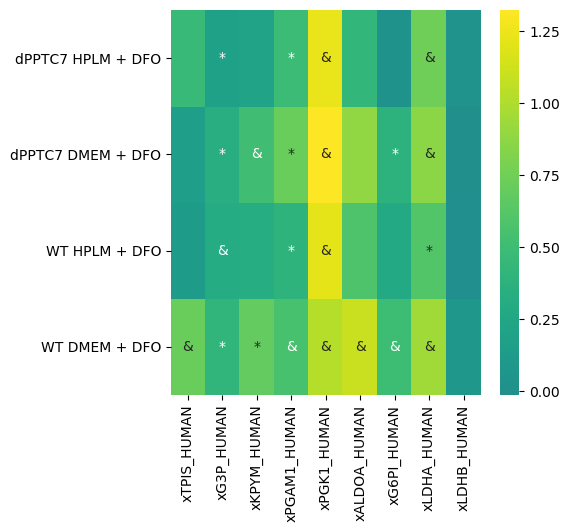

In [138]:
rcParams['figure.figsize'] = 5,5
g=sns.heatmap(DFO_FC_df.astype(float).T, cmap='viridis', center=0, annot=cell_labels.reshape(9,4).T, fmt='')
g.set_ylim([0,4])
#plt.savefig(PATH+'24h_glycolysis.svg')

# UMAP

In [63]:
filter_col = [col for col in dfmerge if col.startswith('x')]
filter_class = ['class']+filter_col 
df_all_complete = dfmerge[filter_col].T.dropna()

In [81]:
classes_ordered = []
i=0
for cls in dfmerge['class']:
    i+=1
    if i % 3 ==0:
        classes_ordered.append(cls)
print(len(classes_ordered))

44


In [104]:
time_ordered = []
i=0
for cls in dfmerge['Control group']:
    i+=1
    if i % 3 ==0:
        time_ordered.append(cls)
#time_ordered
len(time_ordered)

44

In [105]:
'''gen_ordered = []
i=0
for cls in dfmerge['Control group']:
    i+=1
    if i % 3 ==0:
        time_ordered.append(cls)
'''

"gen_ordered = []\ni=0\nfor cls in dfmerge['Control group']:\n    i+=1\n    if i % 3 ==0:\n        time_ordered.append(cls)\n"

In [106]:
genotypes_ordered = [x for i, x in enumerate(dfmerge['Genotype']) if i % 3 ==0]
len(genotypes_ordered)

44

In [107]:
dfmerge.columns

Index(['Unnamed: 0', 'key_0', 'Sample', 'Cell line', 'Genotype', 'Media',
       'Compound', 'concentration', 'Treatment duration', 'Control group',
       ...
       'xCX6B1_HUMAN', 'xTCTP_HUMAN', 'xMARE1_HUMAN', 'xRL30_HUMAN',
       'xVDAC1_HUMAN', 'xFPPS_HUMAN', 'xTRAP1_HUMAN', 'xSYMC_HUMAN',
       'xTXNL1_HUMAN', 'xRBM8A_HUMAN'],
      dtype='object', length=443)

In [108]:
len(classes_ordered)

44

In [109]:
df_all_complete.index

Index(['xACTB_HUMAN', 'xACTG_HUMAN', 'xHNRPF_HUMAN', 'xPTMA_HUMAN',
       'xACTZ_HUMAN', 'xRLA1_HUMAN', 'xVIGLN_HUMAN', 'xNPM3_HUMAN',
       'xHNRDL_HUMAN', 'xCOX5A_HUMAN',
       ...
       'xIDH3B_HUMAN', 'xPPAC_HUMAN', 'xU2AF2_HUMAN', 'xRL35A_HUMAN',
       'xSRRT_HUMAN', 'xIF4H_HUMAN', 'xCLCB_HUMAN', 'xTCTP_HUMAN',
       'xRL30_HUMAN', 'xFPPS_HUMAN'],
      dtype='object', length=341)

In [110]:
## take the average of each of every three values, make new dataframe sequentially
nconditions = len(set(dfmerge['class']))

all_mean_hm = pd.DataFrame(columns=classes_ordered, 
                           index=df_all_complete.index)

pvalues = []

for idx in df_all_complete.index:
    #print(DFO_heatmap.loc[idx])
    for i in range(0, nconditions):
        all_mean_hm.loc[idx][i] = np.mean(df_all_complete.loc[idx][3*i:3*i+3])
        # do some posthoc test for each row
        '''
        if i % 2 ==1:
            pvalues.append(ttest_ind(geno_heatmap.loc[idx][3*(i-1):3*(i-1)+3], geno_heatmap.loc[idx][3*i:3*i+3])[1])'''

In [111]:
all_mean_hm.head()

,WTDMEMCont.,WTHPLMCont.,ΔPPTC7DMEMCont.,ΔPPTC7HPLMCont.,WTDMEMantimycA,WTHPLMantimycA,ΔPPTC7DMEMantimycA,ΔPPTC7HPLMantimycA,WTDMEMroten.,WTHPLMroten.,...,ΔPPTC7DMEMDFO,ΔPPTC7HPLMDFO,WTDMEMdoxycy,WTHPLMdoxycy,ΔPPTC7DMEMdoxycy,ΔPPTC7HPLMdoxycy,WTDMEMCont24h,WTHPLMCont24h,ΔPPTC7DMEMCont24h,ΔPPTC7HPLMCont24h
xACTB_HUMAN,-0.224427,-0.305258,-0.282977,-0.206982,-0.247573,-0.249318,-0.0214853,-0.0473743,-0.416617,-0.171592,...,-0.0362859,0.0913164,-0.346316,-0.113235,-0.127322,-0.131887,-0.174207,-0.0368327,0.0404127,0.195592
xACTG_HUMAN,-1.11772,-0.654105,-0.288152,-0.709504,-0.751993,-0.805601,-0.432145,-0.750041,-0.599679,-0.957854,...,-0.829432,-0.777825,-1.03679,-0.797413,-0.336705,-0.582606,-0.774122,-0.980018,-0.681169,-0.317336
xHNRPF_HUMAN,0.259122,0.406187,-0.130352,-0.528101,0.190047,0.207195,-0.284544,-0.406824,0.0233912,-0.322696,...,-0.33087,-0.378689,-0.0126744,-0.240419,-0.261932,-0.770269,0.209805,-0.0351719,-0.350806,-0.129839
xPTMA_HUMAN,-0.0834146,-0.0409782,-0.475127,-0.277015,-0.00473037,-0.21341,-0.114677,-0.427263,-0.525542,-0.36721,...,-0.244815,-0.170837,-0.329136,-0.254733,-0.336439,-0.313681,-0.26119,-0.247278,-0.244586,-0.32203
xACTZ_HUMAN,0.159184,-0.343499,-0.272936,0.108761,-0.312233,-0.350446,0.0647942,-0.231194,-0.661375,-0.482205,...,-0.0767122,0.167817,0.0163633,-0.0899212,-0.0294749,0.263599,0.106871,-0.177018,0.49639,-0.0891432


In [112]:
import umap

In [113]:
meanhm_np= np.asarray(all_mean_hm.T)

In [114]:
#all_mean_hm.to_csv('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/mean_heatmap.csv')

In [115]:
embedding = umap.UMAP(n_neighbors=43,random_state=42, min_dist=0.5).fit_transform(meanhm_np)

In [116]:
embed_df=pd.DataFrame(embedding, index=all_mean_hm.columns.values)

In [117]:
len(time_ordered)


44

In [118]:
len(time_ordered)

44

In [119]:
embed_df['groups'] = all_mean_hm.columns.values
embed_df['timepoint'] = time_ordered

UMAP uncolored


(array([-5., -4., -3., -2., -1.,  0.,  1.]),
 <a list of 7 Text yticklabel objects>)

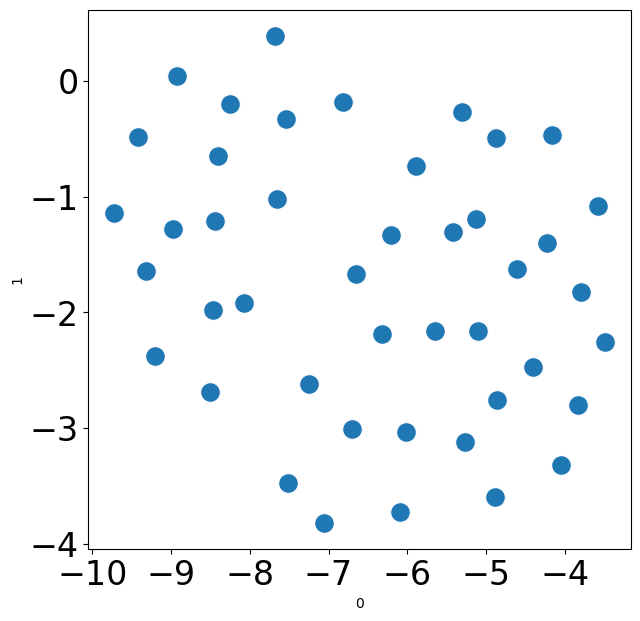

In [124]:
print('UMAP uncolored')

embed_df['groups'] = all_mean_hm.columns.values
embed_df['timepoint'] = time_ordered
rcParams['figure.figsize'] = 7,7
g = sns.scatterplot(x=0, y=1, data=embed_df,  s=200)
plt.xticks(FONTSIZE=24)
plt.yticks(FONTSIZE=24)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/groupmean_UMAP_uncolored.svg')

colored by treatment time group


(array([-5., -4., -3., -2., -1.,  0.,  1.]),
 <a list of 7 Text yticklabel objects>)

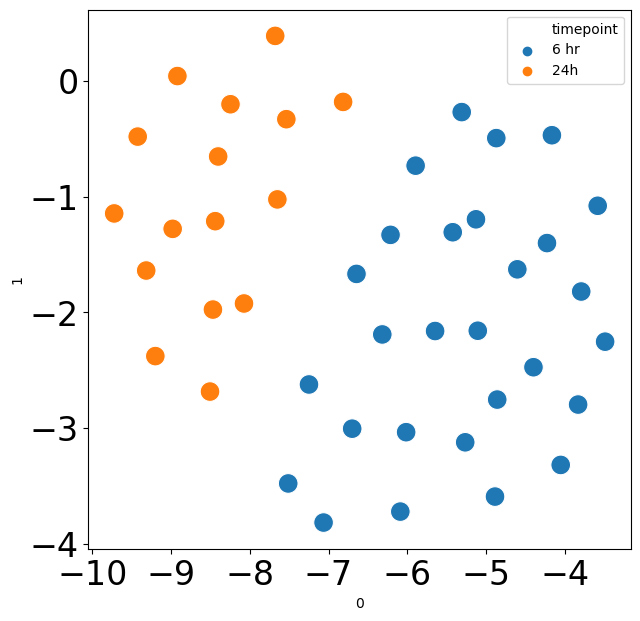

In [126]:
print('colored by treatment time group')
sns.scatterplot(x=0, y=1, data=embed_df, hue='timepoint', s=200)
plt.xticks(FONTSIZE=24)
plt.yticks(FONTSIZE=24)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/groupmean_UMAP_time_color.svg')

In [127]:
embed_df['genotypes'] = [x for i, x in enumerate(dfmerge['Genotype']) if i % 3 ==0]

colored by genotype


(array([-5., -4., -3., -2., -1.,  0.,  1.]),
 <a list of 7 Text yticklabel objects>)

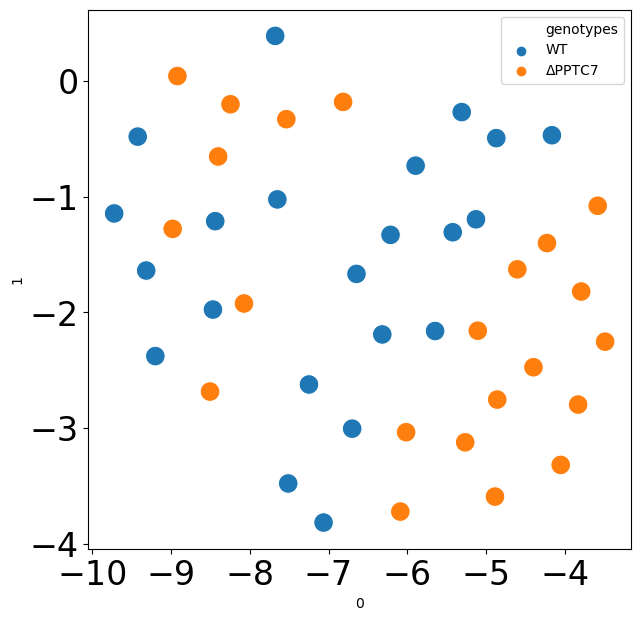

In [128]:
print('colored by genotype')
sns.scatterplot(x=0, y=1, data=embed_df, hue='genotypes', s=200)
plt.xticks(FONTSIZE=24)
plt.yticks(FONTSIZE=24)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/groupmean_UMAP_geno_color.svg')

colored by media


(array([-5., -4., -3., -2., -1.,  0.,  1.]),
 <a list of 7 Text yticklabel objects>)

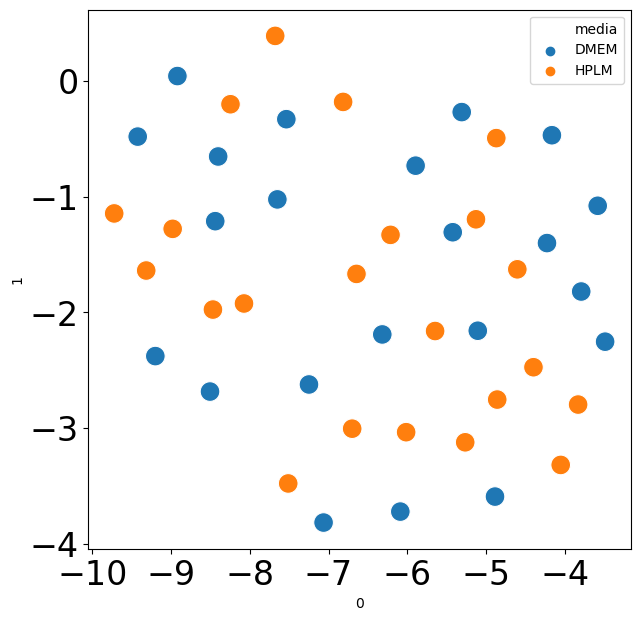

In [129]:
print('colored by media')
embed_df['media'] = [x for i, x in enumerate(dfmerge['Media']) if i % 3 ==0]
#[x for i, x in enumerate(dfmerge['Compound']) if i % 3 ==0]
sns.scatterplot(x=0, y=1, data=embed_df, hue='media', s=200)
plt.xticks(FONTSIZE=24)
plt.yticks(FONTSIZE=24)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/groupmean_UMAP_media_color.svg')

In [130]:
cmpd = [x for i, x in enumerate(dfmerge['Compound']) if i % 3 ==0]
cmpd[-4:] = ['cont24h','cont24h','cont24h','cont24h']
embed_df['compound'] = cmpd

colored by comound and genotype


(array([-5., -4., -3., -2., -1.,  0.,  1.]),
 <a list of 7 Text yticklabel objects>)

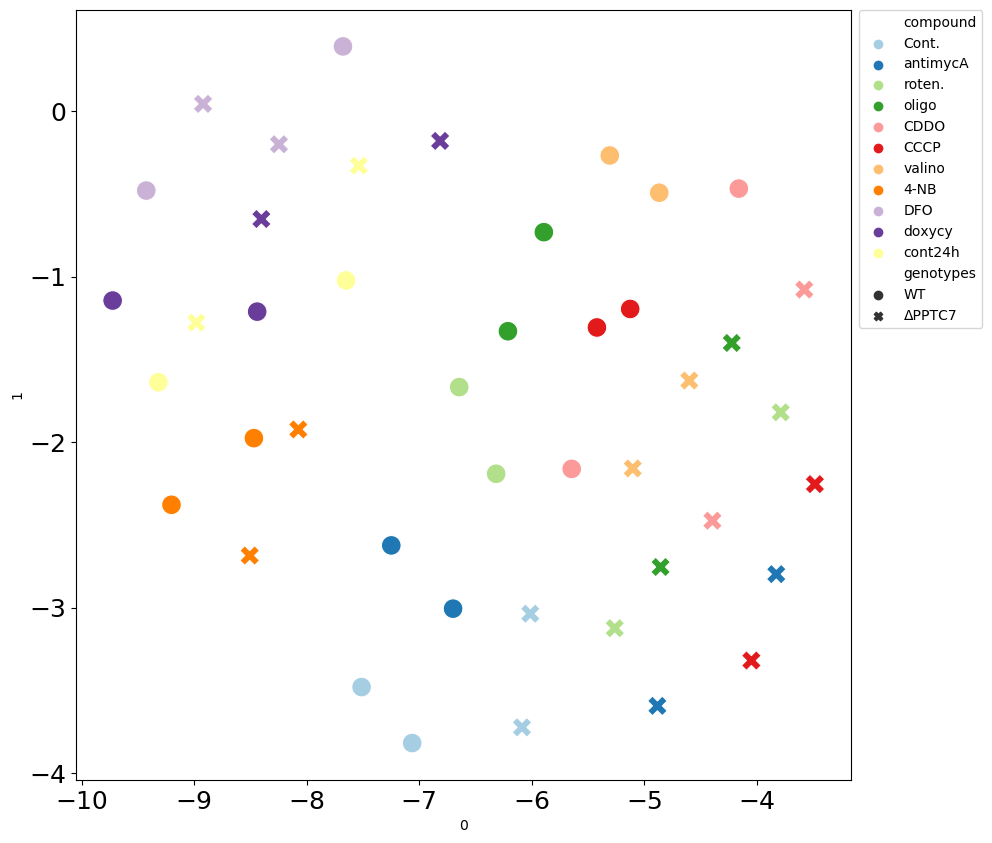

In [131]:
print('colored by comound and genotype')
plt.rcParams['figure.figsize'] = 10,10
cmap = sns.cubehelix_palette(dark=.3, light=.3, as_cmap=True)
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=0, y=1, data=embed_df, hue='compound', style='genotypes', palette='Paired', s=200)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
plt.xticks(FONTSIZE=18)
plt.yticks(FONTSIZE=18)
#plt.tight_layout()
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/groupmean_UMAP_cmpd_color.svg', )

In [132]:
media_sizes=[]
for x in embed_df['media']:
    if x== 'DMEM':
        media_sizes.append(400)
    if x =='HPLM':
        media_sizes.append(200)

colored by compound, media, genotype


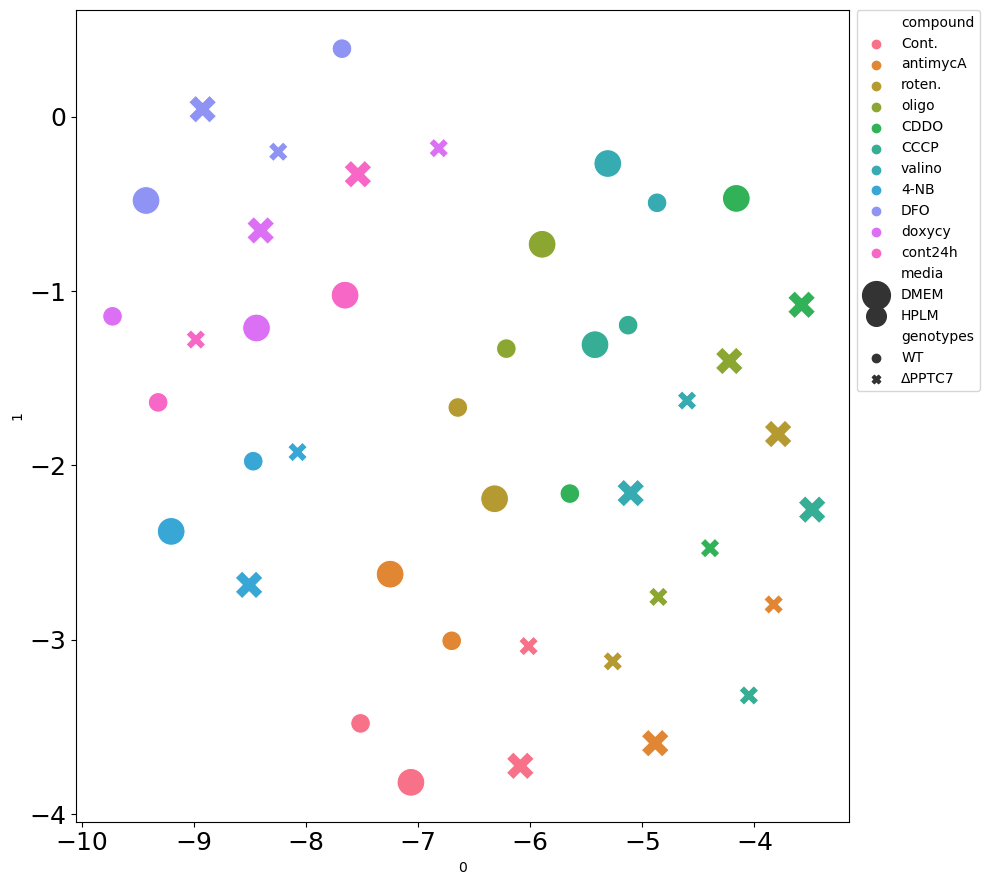

In [135]:
print('colored by compound, media, genotype')
plt.rcParams['figure.figsize'] = 10,10
cmap = sns.cubehelix_palette(dark=.3, light=.3, as_cmap=True)
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=0, y=1, data=embed_df, hue='compound', style='genotypes',  size= 'media',
                sizes=(200, 400))
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
plt.xticks(FONTSIZE=18)
plt.yticks(FONTSIZE=18)
g.set_title('UMAP', FONTSIZE=24)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
#plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/UMAP/groupmean_UMAP_cmpd_color_size.svg', )